#Importando os dados


In [3]:


import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


# Importando os pacotes e lendo o dataframe

In [4]:
#importação de pacotes e primeira visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

df = pd.read_csv(path + "/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
#Checando informações sobre o df

#dimensões
df.shape

(50000, 2)

In [6]:
#Tipos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
#checagem de valores nulos
df.isnull().sum()

,0
review,0
sentiment,0


# ANALISE INICIAL DA DISTRIBUIÇÃO DAS CLASSES

In [8]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


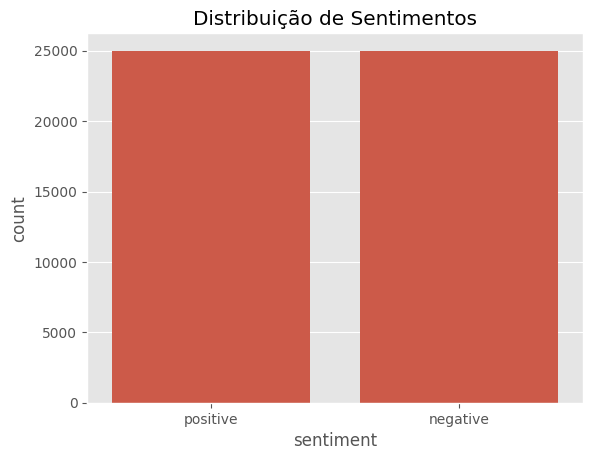

In [9]:
sns.countplot(data=df, x='sentiment')
plt.title('Distribuição de Sentimentos')
plt.show()

In [10]:
#Quantas palavras um review normalmente tem?

df['review_length'] = df['review'].apply(lambda x: len(x.split()))

In [11]:
df['review_length'].describe()

,review_length
count,50000.000000
mean,231.156940
std,171.343997
min,4.000000
25%,126.000000
50%,173.000000
75%,280.000000
max,2470.000000


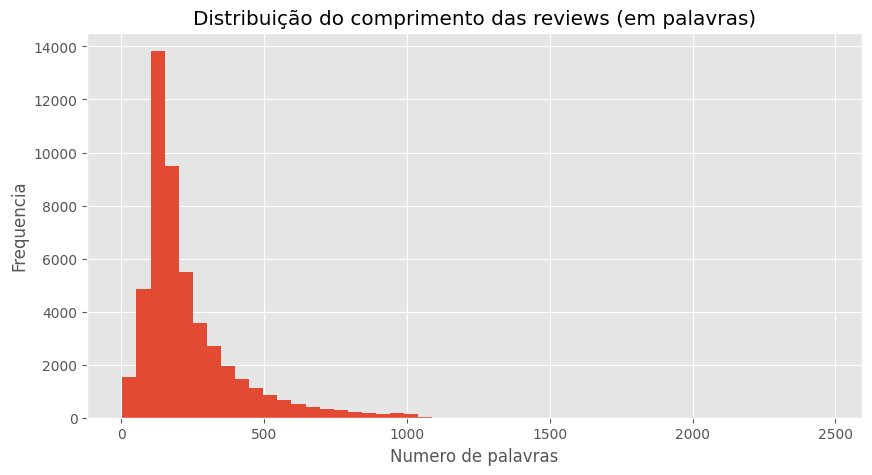

In [12]:
plt.figure(figsize=(10,5))
plt.hist(df['review_length'],bins=50)
plt.title('Distribuição do comprimento das reviews (em palavras)')
plt.xlabel('Numero de palavras')
plt.ylabel('Frequencia')
plt.show()

Podemos ver que os reviews apresentam grande variação na quantidade de palavras, como média de 231 palavras, e em casos extremos chegando a mais de 2400. Isso mostra que nosso dataset possui de analises curtas até analises completas e profundas de filmes

Também vemos uma assimetria no tamanho dos reviews, atravez da longa cauda a direita. Sendo assim, podemos dizer que existe um numero muito pequeno de reviews extremamente longas, essas podem impactar no tempo de processamento e exigir cuidados no pré-processamento.

Há também um grupo de reviews muito curtas, o que pode deixar a classificação nessas amostras muito mais dificies.


In [13]:
#Quais as palavras mais frequentes? - sem limpeza

from collections import Counter

#juntar todo o texto numa unica string
all_words = ' '.join(df['review']).split()

word_counts = Counter(all_words)
word_counts.most_common(20)

[('the', 568735),
 ('a', 306960),
 ('and', 301919),
 ('of', 283625),
 ('to', 261850),
 ('is', 203056),
 ('in', 169981),
 ('I', 132498),
 ('that', 126818),
 ('this', 113726),
 ('it', 107916),
 ('/><br', 100974),
 ('was', 92658),
 ('as', 83130),
 ('with', 82569),
 ('for', 80919),
 ('The', 67317),
 ('but', 66282),
 ('on', 61197),
 ('movie', 60762)]

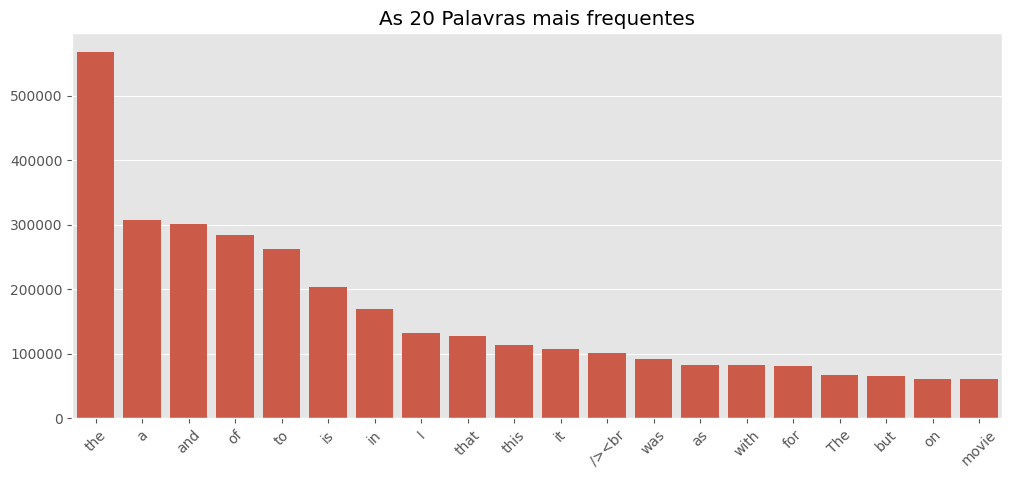

In [14]:
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)
plt.figure(figsize=(12,5))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title('As 20 Palavras mais frequentes')
plt.show()


Vemos a presença de muitas stopwords ('the','and','is)
também de codigo HTML <br />

Teremos que remover algumas dessas durante o pré-processamento


(np.float64(-0.5), np.float64(1199.5), np.float64(599.5), np.float64(-0.5))

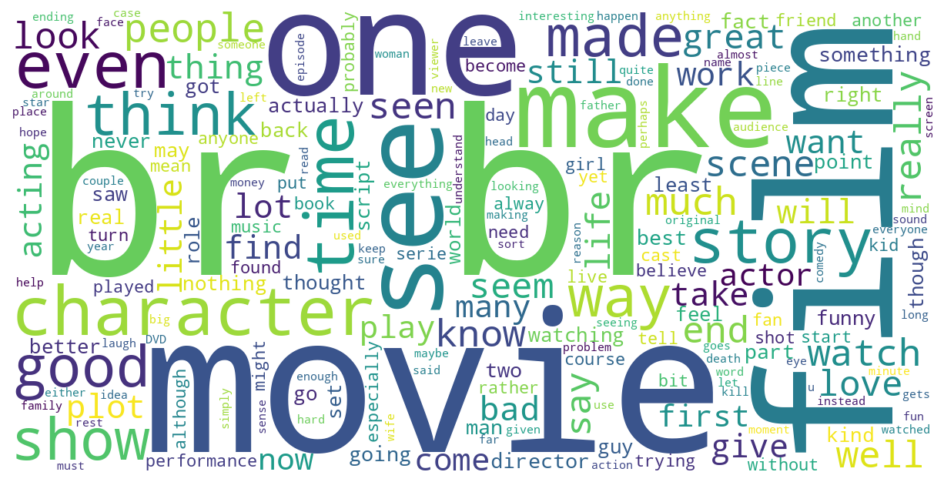

In [15]:
from wordcloud import WordCloud

text = ' '.join(df['review'])
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

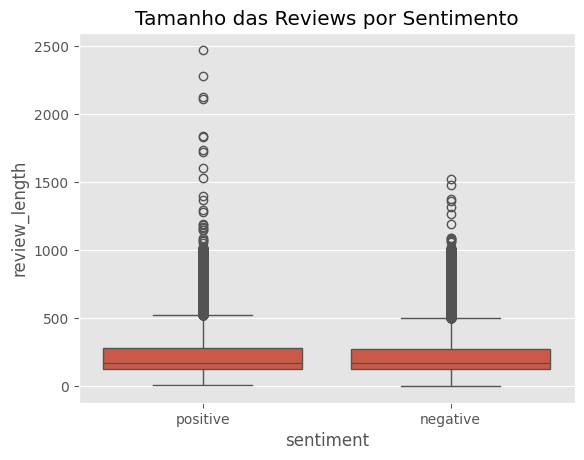

In [16]:
#Será que há diferença de tamanho significativa entre uma review positiva e uma negativa?
sns.boxplot(data=df, x="sentiment", y="review_length")
plt.title("Tamanho das Reviews por Sentimento")
plt.show()


Podemos ver que o tamanho médio não depende do sentimento.
Porém as analises positivas tem outliers mais extremos, talvez indique empolgação na hora de escrever.



In [17]:
#Temos textos duplicados?
df[df['review'].duplicated()].shape

(418, 3)

In [18]:
#temos 418 duplicados, iremos remove-los
df = df.drop_duplicates(subset="review")


O EDA revelou que o dataset do IMDB é bem estruturado, balanceado e rico em texto, mas apresenta variabilidade significativa no tamanho das reviews, presença de ruído (HTML e stopwords) e diferenças sutis no estilo de escrita entre sentimentos positivos e negativos. Esses achados reforçam a necessidade de um pipeline de pré-processamento robusto para padronizar o texto antes da modelagem. De forma geral, os dados são adequados para o desenvolvimento de um modelo de classificação de sentimentos.

# Pré-processamento do texto


In [19]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
#limpeza do texto - remover pontuação, caracter especial, codigos htlm e outros

In [21]:
def clean_text(text):
    # Remove tags HTML
    text = re.sub(r"<.*?>", " ", text)
    # Remove pontuação
    text = re.sub(r"[^\w\s]", " ", text)
    # Remove múltiplos espaços
    text = re.sub(r"\s+", " ", text)
    # Para lowercase
    text = text.lower().strip()
    return text

In [22]:
df["clean_review"] = df["review"].apply(clean_text)




In [23]:
#Remoção de Stopwords

In [24]:
stop_words =set(stopwords.words('english'))

def remove_stopwords(text):
  return ' '.join([word for word in text.split() if word not in stop_words])

In [25]:
df.loc[:, "clean_review"] = df["clean_review"].apply(remove_stopwords)


In [27]:
#Lemmatização

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [28]:
df["clean_review"] = df["clean_review"].apply(lemmatize_text)


#Slipt TREINO/TESTE

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_review"], df["sentiment"],
    test_size=0.2, random_state=42
)


#Vetorização

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


#Modelos

##Regressão Logistica

In [32]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=300)
lr.fit(X_train_tfidf, y_train)
pred_lr = lr.predict(X_test_tfidf)


##Naive Bayes

In [33]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
pred_nb = nb.predict(X_test_tfidf)


##SVM

In [34]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
pred_svm = svm.predict(X_test_tfidf)


#Avaliação dos Modelos

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy LR:", accuracy_score(y_test, pred_lr))
print("Accuracy NB:", accuracy_score(y_test, pred_nb))
print("Accuracy SVM:", accuracy_score(y_test, pred_svm))

print(classification_report(y_test, pred_svm))


Accuracy LR: 0.892104467076737
Accuracy NB: 0.8577190682666129
Accuracy SVM: 0.888171826157104
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4939
    positive       0.88      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917





*   Nosso modelo reconhece bem ambos os sentimentos
*   Não está enviesado (recall quase igual nas duas classes)
*   Não esté superajustado
*   Não está comfundindo positivo/negativo



##Matriz de confusão

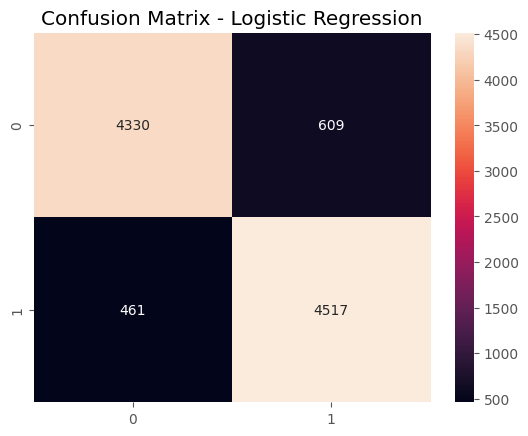

In [38]:
sns.heatmap(confusion_matrix(y_test, pred_lr), annot=True, fmt='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


Matriz quase perfeitamente diagonal -> modelo forte e sem vies

###Quais as palavras mais associadas com cada sentimento

In [43]:
feature_names = tfidf.get_feature_names_out()
coefs = lr.coef_[0]  # logistic regression

top_positive_idx = np.argsort(coefs)[-20:]    # 20 mais positivas
top_negative_idx = np.argsort(coefs)[:20]     # 20 mais negativas

print("Top positive words:")
for i in top_positive_idx:
    print(f"{feature_names[i]}  ({coefs[i]:.3f})")

print("\nTop negative words:")
for i in top_negative_idx:
    print(f"{feature_names[i]}  ({coefs[i]:.3f})")

Top positive words:
entertaining  (3.534)
fun  (3.586)
definitely  (3.693)
enjoyable  (3.842)
well  (3.927)
highly  (3.988)
superb  (4.089)
fantastic  (4.097)
today  (4.330)
enjoyed  (4.394)
hilarious  (4.648)
brilliant  (4.797)
favorite  (4.893)
best  (4.999)
loved  (5.013)
wonderful  (5.382)
amazing  (5.521)
perfect  (5.617)
great  (6.925)
excellent  (7.520)

Top negative words:
worst  (-11.039)
waste  (-8.381)
awful  (-8.178)
bad  (-7.601)
boring  (-7.152)
terrible  (-6.439)
poor  (-6.395)
nothing  (-5.602)
dull  (-5.476)
horrible  (-5.463)
worse  (-5.155)
poorly  (-5.080)
unfortunately  (-5.019)
supposed  (-4.922)
fails  (-4.794)
disappointment  (-4.641)
annoying  (-4.446)
lame  (-4.429)
instead  (-4.408)
disappointing  (-4.394)


###Uma função de Predição Manual
Aqui você pode testar seu review

In [47]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vectorized = tfidf.transform([cleaned])
    pred = lr.predict(vectorized)[0]
    prob = lr.predict_proba(vectorized).max()
    return pred, prob

# Teste
predict_sentiment("I kinda like it. Sometimes fells a bit under expectations, but overall is fun")


('positive', np.float64(0.9665527974265413))

#Pipeline - Sklearn Pipeline

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("model", LogisticRegression(max_iter=200))
])

pipeline.fit(df["clean_review"], df["sentiment"])


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', LogisticRegression(max_iter=200))])

In [49]:
pipeline.predict(["I loved this movie!"])


array(['positive'], dtype=object)